# [Hypothesis Testing in Python](https://www.datacamp.com/completed/statement-of-accomplishment/course/aaa72aac4c8ad6f421a406916da68b4e4b5c8dae)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adamelliotfields/datacamp/blob/main/notebooks/data_science/hypothesis_testing_in_python/notebook.ipynb)

**Contents**
- [Introduction](#Introduction)
- [Two-sample and ANOVA Tests](#Two-sample-and-ANOVA-Tests)
- [Proportion Tests](#Proportion-Tests)
- [Non-parametric Tests](#Non-parametric-Tests)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pingouin import anova, chi2_independence, kruskal, mwu, pairwise_tests, ttest, wilcoxon
from scipy.stats import norm, t
from statsmodels.stats.proportion import proportions_ztest
from warnings import filterwarnings

BASE_URL = "https://raw.githubusercontent.com/adamelliotfields/datacamp/main/notebooks/data_science/hypothesis_testing_in_python/"

# ignore warnings
filterwarnings("ignore", category=UserWarning, module="pingouin")
filterwarnings("ignore", category=RuntimeWarning, module="scipy")

pd.set_option("display.width", 400)

late_shipments = pd.read_csv(BASE_URL + "late_shipments.csv")
sample_dem_data = pd.read_csv(BASE_URL + "sample_dem_data.csv")

In [2]:
display(late_shipments.head())

,id,country,managed_by,fulfill_via,vendor_inco_term,shipment_mode,late_delivery,late,product_group,sub_classification,...,line_item_value,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,freight_cost_usd,freight_cost_groups,line_item_insurance_usd,freight_cost_group
0,36203.0,Nigeria,PMO - US,Direct Drop,EXW,Air,1.0,Yes,HRDT,HIV test,...,266644.00,89.00,0.89,"Alere Medical Co., Ltd.",Yes,1426.0,33279.83,expensive,373.83,expensive
1,30998.0,Botswana,PMO - US,Direct Drop,EXW,Air,0.0,No,HRDT,HIV test,...,800.00,32.00,1.60,"Trinity Biotech, Plc",Yes,10.0,559.89,reasonable,1.72,reasonable
2,69871.0,Vietnam,PMO - US,Direct Drop,EXW,Air,0.0,No,ARV,Adult,...,110040.00,4.80,0.08,Hetero Unit III Hyderabad IN,Yes,3723.0,19056.13,expensive,181.57,expensive
3,17648.0,South Africa,PMO - US,Direct Drop,DDP,Ocean,0.0,No,ARV,Adult,...,361507.95,2.37,0.04,"Aurobindo Unit III, India",Yes,7698.0,11372.23,expensive,779.41,expensive
4,5647.0,Uganda,PMO - US,Direct Drop,EXW,Air,0.0,No,HRDT,HIV test - Ancillary,...,8.50,0.01,0.00,Inverness Japan,Yes,56.0,360.00,reasonable,0.01,reasonable


In [3]:
display(sample_dem_data.head())

,state,county,dem_percent_12,dem_percent_16
0,Alabama,Bullock,76.305900,74.946921
1,Alabama,Chilton,19.453671,15.847352
2,Alabama,Clay,26.673672,18.674517
3,Alabama,Cullman,14.661752,10.028252
4,Alabama,Escambia,36.915731,31.020546


## Introduction

A _hypothesis_ is a statement about an unknown population parameter. A _hypothesis test_ is a trial of two competing hypotheses about a population parameter:
  - _Null Hypothesis_: The existing theory or belief about the population parameter in question ($H_0$).
  - _Alternative Hypothesis_: The new idea presented by the researcher(s) that challenges the existing theory or belief ($H_a$).

> NB: You can write the alternative hypothesis as either $H_a$ or $H_A$.

The null hypothesis is assumed to be true until there is enough evidence to suggest otherwise. When the test concludes, you will either _reject_ or _fail to reject_ the null hypothesis; you do not simply "accept" the alternative hypothesis.

You can think of hypothesis testing as like a courtroom trial for an idea. The null hypothesis is the defendant and is "innocent until proven guilty." When you conduct an experiment, you are gathering evidence against the null hypothesis. If the evidence is strong enough, you can "convict"&mdash;that is, reject the null hypothesis.


### z-score

A $z$-score is a measure of how many standard deviations a data point is from the mean. For example, if you score 2 standard deviations above average on a standardized test, your $z$-score is 2. It is a way of saying you scored much higher than the average student.

$\text{standardized value} = \frac{x - \mu}{\sigma}$

where $x$ is the sample value, $\mu$ is the population mean, and $\sigma$ is the population standard deviation.

$\text{standard error} = \frac{\sigma}{\sqrt{n}}$

where $n$ is the sample size.

$z = \frac{\bar{x} - \mu}{\text{standard error}}$

where $\bar{x}$ is the sample mean.

In [4]:
# make categorical
late_shipments["late"] = late_shipments["late"].astype("category")

late_shipments_boot = []
for i in range(5000):
    sample = late_shipments.sample(frac=1, replace=True, random_state=i)
    late_shipments_boot.append(sample["late"].value_counts(normalize=True)["Yes"])

# late == Yes
late_prop_samp = late_shipments["late"].value_counts(normalize=True)["Yes"]

# hypothesize that the true proportion is 6%
late_prop_hyp = 0.06

# calculate std error
std_error = np.std(late_shipments_boot, ddof=1)

# find z-score of `late_prop_samp`
z_score = (late_prop_samp - late_prop_hyp) / std_error
print(z_score)

0.13421272106979065


### p-value

The $p$-value is the probability of observing a test statistic at least as "extreme" as the one observed by random chance (assuming the null hypothesis is true). A low $p$-value means that it is unlikely for an observation to have happened randomly.

It is very important to understand that a $p$-value is not directly related to probability. For example, a $p$-value of 3 does not imply that there is a 97% chance you are right (or that the null hypothesis is wrong); it means that there is only 3% chance of observing the same result if the null hypothesis is true.

### One-tailed and two-tailed tests

Hypothesis tests check if the sample statistics lie in the _tails_ of the null distribution. The tails of a distribution are the left and right edges of its Probability Density Function (PDF) (i.e., the ends of the bell curve). These are the regions where the probability of observing a value is very low.

<img src="p-value.jpg" width="600" alt="Figure of bell curve with p-value" />

There are three types of tests and the phrasing of the alternative hypothesis determines which test to use:
  - _Two-tailed_: The alternative is **different from** the null
  - _Right-tailed_: The alternative is **greater than** the null
  - _Left-tailed_: The alternative is **less than** the null

where $\mu$ is the population mean and $\mu_0$ is the hypothesized population mean.


In [5]:
late_prop_hyp = 0.06
late_prop_samp = 0.061
std_error = 0.007488520883926666

# z-score
z_score = (late_prop_samp - late_prop_hyp) / std_error

# p-value
p_value = 1 - norm.cdf(z_score)
print(p_value)

0.4468840678346485


### Statistical significance

The $p$-value quantifies the strength of the evidence against the null hypothesis. A small $p$-value would make us reject the null hypothesis in favor of the alternative hypothesis.

The _significance level_ ($\alpha$) is essentially the threshold for rejecting the null hypothesis. It is set prior to the experiment and is usually set to 0.05 (5%). If $p \leq \alpha$, we reject the null hypothesis.


In [6]:
# 95% confidence interval from `late_shipments_boot` using quantile
lower = np.quantile(late_shipments_boot, 0.025)
upper = np.quantile(late_shipments_boot, 0.975)
print(lower)
print(upper)

0.046
0.075


## Two-sample and ANOVA Tests

### Test statistics

The test statistic ($t$) is a numerical summary of the data that measures how far the sample statistic diverges from what we would expect if the null hypothesis were true. It is used to calculate the $p$-value.

The formula for calculating $t$ with a one-sample $t$-test is:

$t = \frac{\bar{x} - \mu_0}{\frac{s}{\sqrt{n}}}$

where $\bar{x}$ is the sample mean, $\mu_0$ is the hypothesized population mean, $s$ is the sample standard deviation, and $n$ is the sample size.

### Two-sample t-test

The two-sample $t$-test is used to compare the means of two independent samples. It is used to test whether the means of two populations are equal:

$t = \frac{\bar{x_1} - \bar{x_2}}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}$

where $\bar{x_1}$ and $\bar{x_2}$ are the sample means, $s_1$ and $s_2$ are the sample standard deviations, and $n_1$ and $n_2$ are the sample sizes.

In [7]:
xbar_no = 1897.7912673056444
xbar_yes = 2715.6721311475408
s_no = 3154.0395070841687
s_yes = 2544.688210903328
n_no = 939
n_yes = 61
alpha = 0.05

# calculate test statistic
numerator = xbar_no - xbar_yes
denominator = np.sqrt((s_no**2 / n_no) + (s_yes**2 / n_yes))
t_stat = numerator / denominator
print(t_stat)

-2.3936661778766433


### t-distributions

Test statistics follow a $t$-distribution, which have a parameter known as _degrees of freedom_ or $df$. The degrees of freedom for a one-sample $t$-test is $n - 1$ and for a two-sample $t$-test is $n_1 + n_2 - 2$.

The $t$-distribution gets closer to the normal distribution as the degrees of freedom increase. The tails in a $t$-distribution get "fatter" as the degrees of freedom decrease. In fact, a normal distribution is a $t$-distribution with infinite degrees of freedom.

<img src="t-distribution.jpg" width="600" alt="t-distribution" />

In [8]:
df = n_no + n_yes - 2
p_value = t.cdf(t_stat, df=df)

# 0.008 is below 0.050, so we reject the null hypothesis
print(p_value)

0.008432382146249523


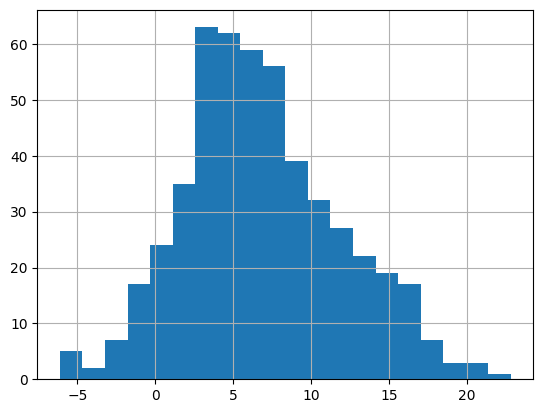

In [9]:
# calculate difference in votes between `dem_percent_12` and `dem_percent_16`
sample_dem_data["diff"] = sample_dem_data["dem_percent_12"] - sample_dem_data["dem_percent_16"]

# find the mean and standard deviation
xbar_diff = sample_dem_data["diff"].mean()
s_diff = sample_dem_data["diff"].std(ddof=1)

# hist plot with 20 bins
sample_dem_data["diff"].hist(bins=20)
plt.show()

In [10]:
test_results = ttest(
    x=sample_dem_data["diff"],
    y=0,
    alternative="two-sided",
)

paired_test_results = ttest(
    x=sample_dem_data["dem_percent_12"],
    y=sample_dem_data["dem_percent_16"],
    alternative="two-sided",
    paired=True,
)

print(
    test_results,
    "\n\n",
    paired_test_results,
)

                T  dof alternative          p-val         CI95%   cohen-d        BF10  power
T-test  30.298384  499   two-sided  3.600634e-115  [6.39, 7.27]  1.354985  2.246e+111    1.0 

                 T  dof alternative          p-val         CI95%   cohen-d        BF10  power
T-test  30.298384  499   two-sided  3.600634e-115  [6.39, 7.27]  0.454202  2.246e+111    1.0


### Analysis of variance (ANOVA)

_ANOVA_ is a statistical test used to determine variability between two or more groups.

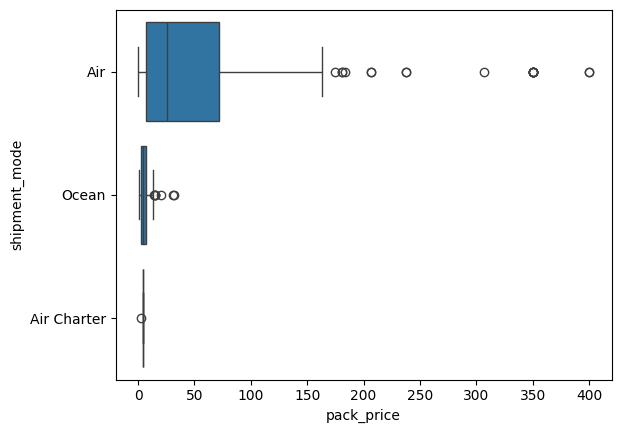

In [11]:
# calculate mean and standard deviation `pack_price` for each `shipment_mode`
xbar_pack_by_mode = late_shipments.groupby("shipment_mode")["pack_price"].mean()
s_pack_by_mode = late_shipments.groupby("shipment_mode")["pack_price"].std(ddof=1)

# box plot `shipment_mode` vs `pack_price`
sns.boxplot(
    late_shipments,
    x="pack_price",
    y="shipment_mode",
)
plt.show()

In [12]:
# ANOVA test for `pack_price` across `shipment_mode`
anova_results = anova(
    data=late_shipments,
    dv="pack_price",
    between="shipment_mode",
)
display(anova_results)

,Source,ddof1,ddof2,F,p-unc,np2
0,shipment_mode,2,997,21.8646,5.089479e-10,0.042018


In [13]:
pairwise_results = pairwise_tests(
    data=late_shipments,
    dv="pack_price",
    between="shipment_mode",
    padjust="bonf",
)
display(pairwise_results)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,shipment_mode,Air,Air Charter,False,True,21.179625,600.685682,two-sided,8.748346e-75,2.624504e-74,bonf,5.809e+76,0.726592
1,shipment_mode,Air,Ocean,False,True,19.335760,986.979785,two-sided,6.934555e-71,2.080367e-70,bonf,1.129e+67,0.711119
2,shipment_mode,Air Charter,Ocean,False,True,-3.170654,35.615026,two-sided,3.123012e-03,9.369037e-03,bonf,15.277,-0.423775


## Proportion Tests

Another formula for calculating the standard error is:

$\text{standard error} = \sqrt{\frac{p_0 \cdot (1 - p_0)}{n}}$

where $p_0$ is the hypothesized population proportion and $n$ is the sample size. It is used to calculate the $z$-score:

$z = \frac{\hat{p} - p_0}{\text{standard error}}$

where $\hat{p}$ is the sample proportion.

### One-sample proportion tests

In [14]:
# hypothesize that proportion of late shipments is 6%
p_0 = 0.06

# calculate sample proportion of late shipments
p_hat = late_shipments["late"].value_counts(normalize=True)["Yes"]

# calculate sample size
n = len(late_shipments)

# calculate test statistic
numerator = p_hat - p_0
denominator = np.sqrt((p_0 * (1 - p_0)) / n)
z_score = numerator / denominator

# calculate p-value
p_value = 1 - norm.cdf(z_score)
print(p_value)

0.44703503936503364


### Two-sample proportion tests

In [15]:
# calculate pooled estimate of the population proportion
index = pd.MultiIndex.from_tuples(
    [
        ("expensive", "Yes"),
        ("reasonable", "Yes"),
    ],
    names=[
        "freight_cost_group",
        "late",
    ],
)
p_hats = pd.Series([0.083, 0.035], index=index, name="late")
ns = pd.Series(
    [545, 455],
    index=["expensive", "reasonable"],
    name="late",
)
p_hat = (p_hats["reasonable"] * ns["reasonable"] + p_hats["expensive"] * ns["expensive"]) / (
    ns["reasonable"] + ns["expensive"]
)

# calculate standard error
p_hat_times_not_p_hat = p_hat * (1 - p_hat)
p_hat_times_not_p_hat_over_ns = (
    p_hat_times_not_p_hat / ns["expensive"] + p_hat_times_not_p_hat / ns["reasonable"]
)
std_error = np.sqrt(p_hat_times_not_p_hat_over_ns.sum())

# calculate z-score
z_score = (p_hats["expensive"] - p_hats["reasonable"]) / std_error

# calculate p-value
p_value = 1 - norm.cdf(z_score)
print(p_value)

[0.00080416]


#### Using statsmodels

In [16]:
late_by_freight_cost_group = late_shipments.groupby("freight_cost_group")["late"].value_counts()

# collect "Yes" counts
success_counts = np.array(
    [
        late_by_freight_cost_group["expensive"]["Yes"],
        late_by_freight_cost_group["reasonable"]["Yes"],
    ]
)

# collect totals
n = np.array(
    [
        late_by_freight_cost_group["expensive"].sum(),
        late_by_freight_cost_group["reasonable"].sum(),
    ]
)

# run two-proportion z-test
z_score, p_value = proportions_ztest(
    count=success_counts,
    nobs=n,
    alternative="larger",
)
print(z_score)
print(p_value)

3.1190401865206128
0.0009072060637051224


### Chi-square test of independence

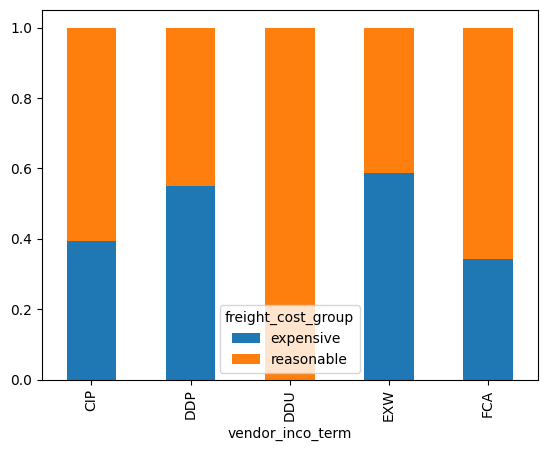

In [17]:
# proportion of `freight_cost_group` by `vendor_inco_term`
props = late_shipments.groupby("vendor_inco_term")["freight_cost_group"].value_counts(
    normalize=True
)

# widen
wide_props = props.unstack()

# proportional stacked bar plot
wide_props.plot(kind="bar", stacked=True)
plt.show()

In [18]:
# chi-square test of independence
expected, observed, stats = chi2_independence(
    data=late_shipments,
    x="vendor_inco_term",
    y="freight_cost_group",
)
display(stats)

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,30.134064,4.0,0.000005,0.173592,0.997225
1,cressie-read,0.666667,30.139025,4.0,0.000005,0.173606,0.997229
2,log-likelihood,0.000000,30.593069,4.0,0.000004,0.174909,0.997549
3,freeman-tukey,-0.500000,NaN,4.0,NaN,NaN,NaN
4,mod-log-likelihood,-1.000000,inf,4.0,0.000000,inf,NaN
5,neyman,-2.000000,NaN,4.0,NaN,NaN,NaN


## Non-parametric Tests

In [19]:
# paired t-test `dem_percent_12` and `dem_percent_16`
paired_test_results = ttest(
    x=sample_dem_data["dem_percent_12"],
    y=sample_dem_data["dem_percent_16"],
    alternative="two-sided",
    paired=True,
)
display(paired_test_results)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,30.298384,499,two-sided,3.600634e-115,"[6.39, 7.27]",0.454202,2.246e+111,1.0


In [20]:
# Wilcoxon signed-rank test `dem_percent_12` and `dem_percent_16`
wilcoxon_test_results = wilcoxon(
    x=sample_dem_data["dem_percent_12"],
    y=sample_dem_data["dem_percent_16"],
    alternative="two-sided",
)
display(wilcoxon_test_results)

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,2401.0,two-sided,1.780396e-77,0.961661,0.644816


In [21]:
# select `weight_kilograms` and `late`
weight_vs_late = late_shipments[["weight_kilograms", "late"]]

# widen
weight_vs_late_wide = weight_vs_late.pivot(columns="late", values="weight_kilograms")

# two-sided Wilcoxon-Mann-Whitney test
wmw_test_results = mwu(
    x=weight_vs_late_wide["Yes"],
    y=weight_vs_late_wide["No"],
    alternative="two-sided",
)
display(wmw_test_results)

,U-val,alternative,p-val,RBC,CLES
MWU,38145.0,two-sided,0.000014,-0.331902,0.665951


In [22]:
# Kruskal-Wallis test `weight_kilograms` across `shipment_mode`
kw_test_results = kruskal(
    data=late_shipments,
    dv="weight_kilograms",
    between="shipment_mode",
)
display(kw_test_results)

,Source,ddof1,H,p-unc
Kruskal,shipment_mode,2,125.096618,6.848799e-28
